Y-DATA 2020/21<br/>
Deep Learning HW4<br/>
Serge Tochilov

# Image Classification - Tensorboard, Batch Norm and Custom Loss Functions
In this exercise, you'll continue to work with our neural network for classifying Israeli Politicians.  
We will use tensorboard to monitor the training process and model performance.  

For the questions below, please use the network architecture you suggested in Q8 of HW1.
This time, we provide you with a clean dataset of Israeli Politicians, that doesn't include multiple politicians in the same image, in the folder `data/israeli_politicians_cleaned.zip`.

## Tensorboard
TensorBoard provides visualization and tooling for machine learning experimentation:
- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data
- Profiling programs

Tensorboard worked originally with Tensorflow but can now be used with PyTorch as well.  
You can embed a tensorboard widget in a Jupyter Notebook, although if you're not using Google Colab we recommend that you open tensorboard separately.

To get started with Tensorboard, please read the following pages:

PyTorch related:
1. https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
1. https://becominghuman.ai/logging-in-tensorboard-with-pytorch-or-any-other-library-c549163dee9e
1. https://towardsdatascience.com/https-medium-com-dinber19-take-a-deeper-look-at-your-pytorch-model-with-the-new-tensorboard-built-in-513969cf6a72
1. https://pytorch.org/docs/stable/tensorboard.html
1. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/04-utils/tensorboard

Tensorflow related:
1. https://itnext.io/how-to-use-tensorboard-5d82f8654496
1. https://www.datacamp.com/community/tutorials/tensorboard-tutorial
1. https://medium.com/@anthony_sarkis/tensorboard-quick-start-in-5-minutes-e3ec69f673af
1. https://www.guru99.com/tensorboard-tutorial.html
1. https://www.youtube.com/watch?time_continue=1&v=s-lHP8v9qzY&feature=emb_logo
1. https://www.youtube.com/watch?v=pSexXMdruFM


### Starting Tensorboard
Jupyter Notebook has extensions for displaying TensorBoard inside the notebook. Still, I recommend that you run it separately, as it tends to get stuck in notebooks.

The syntax to load TensorBoard in a notebook is this:
```python
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir ./logs
```

In the shell, you can instead run:
```
tensorboard --logdir ./logs
```

> We implement the HW4 assignment in Google Colab using GPU runtime type.

> First we load precomputed logs (stored in `logs/hw4`) so there's no need to rerun the whole notebook.

In [ ]:
import requests
from zipfile import ZipFile

def unzip(url, zip_file, out_dir='./'):

    r = requests.get(url, allow_redirects=True)
    open(zip_file, 'wb').write(r.content)

    # extract all the contents of zip file in current directory
    with ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.extractall(path=out_dir)

In [ ]:
# download precomputed logs
url = 'https://drive.google.com/uc?export=download&id=1u5t_tponGrjARjN1bQEXRvKJ7QadF5Pd'
unzip(url, 'hw4-tensorflow-logs.zip', out_dir='logs/')

> Then we load `tensorboard` extension, and the next cell output will contain the TensorBoard widget with precomputed logs displayed.

> If you want to rerun the whole notebook and see new statistics, click on the reload icon (in the top right corner) after the notebook finishes running. Unlike the precomputed, new logs won't have `hw4-` prefix.

In [ ]:
# load the TensorBoard notebook extension
%load_ext tensorboard
!mkdir -p ./logs
%tensorboard --logdir ./logs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

import torch.utils
from torch.optim import SGD, lr_scheduler
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
import torchvision.utils
from torchvision import datasets, transforms

### Show images using TensorBoard

> Loading of the cleaned "Israeli politicians" dataset.

In [ ]:
from pathlib import Path

# make working directory
data_dir = './data/israeli_politicians_cleaned'
Path(data_dir).mkdir(parents=True, exist_ok=True)

# download our dataset 'israeli_politicians_cleaned.zip'
url = 'https://drive.google.com/uc?export=download&id=1vTYVsg9BHjvzyVSnHV56fs59aF6HHYvt'
unzip(url, data_dir + '.zip', data_dir)

In [ ]:
MEANS = [0.485, 0.456, 0.406]
STDS = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STDS)]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STDS)])}

In [ ]:
def set_dataloaders(data_transforms):

    image_datasets = {
        x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
            for x in ['train', 'val']}

    dataloaders = {
        'train': torch.utils.data.DataLoader(
            image_datasets['train'], batch_size=20, shuffle=True, num_workers=2),
        'val': torch.utils.data.DataLoader(
            image_datasets['val'], batch_size=20, shuffle=True, num_workers=2)}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    print('dataset_sizes: ', dataset_sizes)

    class_names = image_datasets['train'].classes
    print('class_names:', class_names)

    return dataloaders, dataset_sizes, class_names

In [ ]:
dataloaders, dataset_sizes, class_names = set_dataloaders(data_transforms)

dataset_sizes:  {'train': 812, 'val': 202}
class_names: ['ayelet_shaked', 'benjamin_netanyahu', 'benny_gantz', 'danny_danon', 'gideon_saar', 'kostya_kilimnik', 'naftali_bennett', 'ofir_akunis', 'yair_lapid']


In [ ]:
def grid_imshow(img, ax):
    ''' helper function to show an image '''

    # transpose and show
    ax.imshow(np.transpose(img, (1, 2, 0)))

In [ ]:
def min_max_norm(img):
    ''' minmax normalize images '''
    
    images = img - np.amin(img.numpy(), axis=(2, 3), keepdims=True)
    return images / np.amax(images.numpy(), axis=(2, 3), keepdims=True)

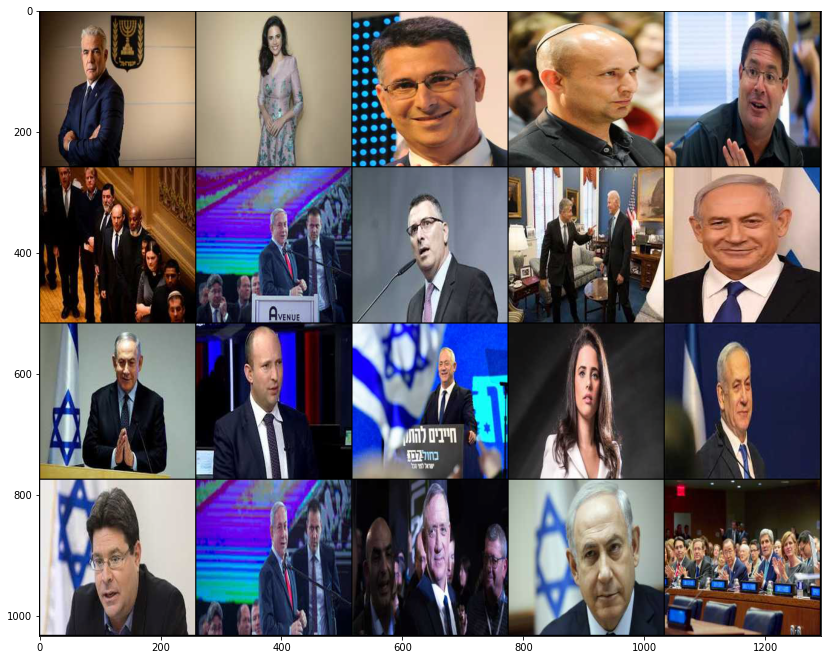

In [ ]:
# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(min_max_norm(images), nrow=5)

# show images
plt.figure(figsize=(14, 14))
grid_imshow(img_grid, plt.gca())
plt.show()

# write to tensorboard
writer = SummaryWriter('logs')
writer.add_image('batch_of_israeli_politicians_images', img_grid)
writer.close()

> The images are also available under Tensorboard **IMAGES** tab. Note that Tensorboard expects $[0,1]$ normalized images.

### Inspect the model graph
You can print a network object to find useful information about it:

> We use the model architecture from our **HW1 Q1** submission, which has no more than $8$ layers and $10$M parameters.

In [ ]:
class Net(nn.Module):

    def __init__(self, k_size=3, fc1_fc2=2345):

        k_2 = k_size // 2

        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(k_size, k_size), stride=(1, 1), padding=(k_2, k_2))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(k_size, k_size), stride=(1, 1), padding=(k_2, k_2))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(k_size, k_size), stride=(1, 1), padding=(k_2, k_2))
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        self.fc1 = nn.Linear(256 * 4 * 4, fc1_fc2)
        self.fc2 = nn.Linear(fc1_fc2, 9)


    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


activations = {}

def get_activation(name):

    activations[name] = []

    def hook(model, input, output):
        del activations[name]
        activations[name] = output.detach()

    return hook

In [ ]:
model = Net()

In [ ]:
print(model)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=2345, bias=True)
  (fc2): Linear(in_features=2345, out_features=9, bias=True)
)


TensorBoard can help visualize the network graph. It takes practice reading these.

Write the graph to TensorBoard and review it.

In [ ]:
writer.add_graph(model, images)
writer.close()

> The model's graph is available under Tensorboard **GRAPH** tab. We push the model together with one image batch ($20$ images). The graph allows hierarchical browsing of all elements of the model, displays their type, input-output flow and parameter values. Also, the computing environment and run statistics, such as device, memory, runtime, TPU compatibility is available. The widget is able to monitor model runs in realtime.

You can also use the package `torchsummary` for a fuller info on the model:

In [ ]:
from torchsummary import summary

channels, H, W = 3, 256, 256
summary(model, input_size=(channels, H, W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
         MaxPool2d-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 64, 64]          73,856
         MaxPool2d-4          [-1, 128, 16, 16]               0
            Conv2d-5          [-1, 256, 16, 16]         295,168
         MaxPool2d-6            [-1, 256, 4, 4]               0
            Linear-7                 [-1, 2345]       9,607,465
            Linear-8                    [-1, 9]          21,114
Total params: 9,999,395
Trainable params: 9,999,395
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 38.80
Params size (MB): 38.14
Estimated Total Size (MB): 77.69
----------------------------------------------------------------


## Train the network
Next, we'll train the network. In the training loop, log relevant metrics that would allow you to plot in TensorBoard:

1. The network loss
1. Train and test error
1. Average weight in the first layer
1. Histogram of weights in the first layer

> We log all the required statistics to Tensorboard. Network loss, accuracy, average weights are under the **SCALARS** tab, whereas convolution layer $1$ weight distributions and fully connected layer $1$ activation distributions are under **HISTOGRAMS** tab. The models PR curves are under **PR CURVES** tab. We store the above statistics after each epoch.

> We employ **Adam** optimizer with default parameters, what significantly speeds up convergence. Also, we use a rather modest ($0.7$) learning rate decay factor which we apply every 3 epochs, $20$ learning epochs, and $20$ retraining epochs starting with initial learning rate. The initial trains have an even run number and prefix `_A`, while the retraining $-$ odd number and prefix `_B`.

In [ ]:
def define_params(model):

    # for a multi-class problem, you'd usually prefer CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss()

    # # use Stochastic Gradient Descent as the optimizer,
    # # with a learning rate of 0.001 and momentum
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters())

    # decay LR by a factor of 0.7 every 3 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

    num_epochs = 20

    return criterion, optimizer, scheduler, num_epochs

> We assign incremental number to each run, to easily navigate through logs at Tensorboard.

In [ ]:
run = 1

In [ ]:
def train_model(model, dataloaders, define_params_f, run, run_title='',
    phases=('train', 'val'), rnd_labels=False):

    writer = SummaryWriter(f'logs/run{run:02d}_{run_title}')
    print(f'Run #{run:02d} {run_title}\n')

    model.fc1.register_forward_hook(get_activation(run_title))

    # move model to GPU if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion, optimizer, scheduler, num_epochs = define_params_f(model)
    if phases == ('val',):
        num_epochs = 1

    softmax = nn.Softmax(dim=1)
    validation, prediction = [], []

    # full class index
    classes_idx = np.arange(len(class_names))

    global_step = 0

    for epoch in range(num_epochs):

        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in phases:

            if phase == 'train':
                # set model to training mode
                model.train()  
            else:
                # set model to evaluate mode; in evaluate mode, we don't perform
                # backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:

                global_step += 1

                if rnd_labels and phase == 'train':
                    # insert random labels

                    batch_idx = np.arange(len(labels))
                    n_rnd = len(labels) // 10
                    rnd_class = np.random.choice(classes_idx, n_rnd)
                    rnd_sample = np.random.choice(batch_idx, n_rnd)
                    labels[rnd_sample] = torch.tensor(rnd_class)

                # prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase == 'train'):

                    # apply the model to the inputs; after applying softmax the output
                    # is the probability of each class, but here we don't need it as we find max output
                    # whereas softmax is monotonic and doesn't interfere with maxing
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        # ==== backward pass + optimizer step ====
                        # in train mode we track the gradients to allow back-propagation

                        # perform a step in the opposite direction of the gradient
                        loss.backward() 

                        # adapt the optimizer
                        optimizer.step()

                # collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                validation.extend((preds == labels.data).ravel().tolist())
                prediction.extend(softmax(outputs)[np.arange(preds.shape[0]), preds].ravel().tolist())

            if phase == 'train':

                # adjust the learning rate based on the scheduler
                scheduler.step()  

                writer.add_scalar('conv1 average weight',
                    model.conv1.weight.data.mean(), global_step)
                writer.add_histogram('conv1 weights histogram',
                    model.conv1.weight, global_step)
                writer.add_histogram('fc1 activations histogram',
                    activations[run_title], global_step)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            writer.add_scalar(phase + ' loss', epoch_loss, global_step=global_step)
            writer.add_scalar(phase + ' accuracy', epoch_acc, global_step=global_step)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            writer.add_pr_curve(phase + ' precision recall curve',
                np.array(validation), np.array(prediction), global_step=global_step)
            validation.clear()
            prediction.clear()

    writer.close()
    return model.to(torch.device('cpu')), run + 1

> First we train the default parameters model.

In [ ]:
model, run = train_model(model, dataloaders, define_params, run, run_title='default_A')

Run #01 default_A

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 2.1409 Acc: 0.2438
val Loss: 2.0825 Acc: 0.2376
Epoch 2/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 2.0073 Acc: 0.2845
val Loss: 2.0435 Acc: 0.2376
Epoch 3/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.8890 Acc: 0.3128
val Loss: 1.8567 Acc: 0.3168
Epoch 4/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.6511 Acc: 0.4101
val Loss: 1.7333 Acc: 0.3762
Epoch 5/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.3479 Acc: 0.5086
val Loss: 1.8011 Acc: 0.4109
Epoch 6/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.0605 Acc: 0.6330
val Loss: 1.4591 Acc: 0.5099
Epoch 7/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6814 Acc: 0.7635
val Loss: 1.3542 Acc: 0.5792
Epoch 8/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.4218 Acc: 0.8781
val Loss: 1.6668 Acc: 0.6040
Epoch 9/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.2631 Acc: 0.9113
val Loss: 1.4770 Acc: 0.6584
Epoch 10/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1123 Acc: 0.9766
val Loss: 1.6460 Acc: 0.6634
Epoch 11/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0491 Acc: 0.9914
val Loss: 1.8327 Acc: 0.6584
Epoch 12/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0229 Acc: 1.0000
val Loss: 1.9653 Acc: 0.6634
Epoch 13/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0122 Acc: 1.0000
val Loss: 1.9114 Acc: 0.6584
Epoch 14/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0081 Acc: 1.0000
val Loss: 1.9675 Acc: 0.6584
Epoch 15/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0062 Acc: 1.0000
val Loss: 2.0311 Acc: 0.6733
Epoch 16/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0050 Acc: 1.0000
val Loss: 2.0893 Acc: 0.6683
Epoch 17/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0042 Acc: 1.0000
val Loss: 2.1049 Acc: 0.6683
Epoch 18/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0037 Acc: 1.0000
val Loss: 2.1334 Acc: 0.6683
Epoch 19/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0033 Acc: 1.0000
val Loss: 2.1409 Acc: 0.6683
Epoch 20/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0031 Acc: 1.0000
val Loss: 2.1614 Acc: 0.6683


In [ ]:
model, run = train_model(model, dataloaders, define_params, run, run_title='default_B')

Run #02 default_B

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.2421 Acc: 0.9113
val Loss: 1.9147 Acc: 0.6337
Epoch 2/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0767 Acc: 0.9791
val Loss: 2.7096 Acc: 0.6436
Epoch 3/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0473 Acc: 0.9865
val Loss: 2.3916 Acc: 0.6386
Epoch 4/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0754 Acc: 0.9778
val Loss: 2.4867 Acc: 0.6337
Epoch 5/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0440 Acc: 0.9914
val Loss: 2.7115 Acc: 0.6287
Epoch 6/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0184 Acc: 0.9963
val Loss: 2.6528 Acc: 0.6634
Epoch 7/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0061 Acc: 1.0000
val Loss: 2.5568 Acc: 0.6584
Epoch 8/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0011 Acc: 1.0000
val Loss: 2.6516 Acc: 0.6634
Epoch 9/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0006 Acc: 1.0000
val Loss: 2.8469 Acc: 0.6683
Epoch 10/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0004 Acc: 1.0000
val Loss: 2.8412 Acc: 0.6634
Epoch 11/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0003 Acc: 1.0000
val Loss: 2.8959 Acc: 0.6584
Epoch 12/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0003 Acc: 1.0000
val Loss: 2.8825 Acc: 0.6683
Epoch 13/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0003 Acc: 1.0000
val Loss: 2.9489 Acc: 0.6634
Epoch 14/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0002 Acc: 1.0000
val Loss: 2.9537 Acc: 0.6634
Epoch 15/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0002 Acc: 1.0000
val Loss: 2.9493 Acc: 0.6634
Epoch 16/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0002 Acc: 1.0000
val Loss: 2.9863 Acc: 0.6634
Epoch 17/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0002 Acc: 1.0000
val Loss: 2.9945 Acc: 0.6634
Epoch 18/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0002 Acc: 1.0000
val Loss: 2.9981 Acc: 0.6584
Epoch 19/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0002 Acc: 1.0000
val Loss: 3.0176 Acc: 0.6634
Epoch 20/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0002 Acc: 1.0000
val Loss: 3.0137 Acc: 0.6634


### Precision-Recall Curve
Use TensorBoard to plot the precision-recall curve:

> See the **PR CURVES** tab.

### Display Model Errors
A valuable practice is to review errors made by the model in the test set. These might reveal cases of bad preprocessing or lead to come up with improvements to your original model.

Show $12$ images of errors made by the model. For each, display the true and predicted classes, and the model confidence in its answer.

In [ ]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images '''

    output = net(images)

    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())

    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(model, dataiter, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the model's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the `images_to_probs` function. '''

    # plot the images in the batch, along with predicted and true labels
    fig, axs = plt.subplots(3, 4, figsize=(14, 12))

    idx, samp_idx = 0, 0
    while True:

        images, labels = dataiter.next()
        preds, probs = images_to_probs(model, images)
        images = min_max_norm(images)

        for image, label, pred, prob in zip(images, labels, preds, probs):

            samp_idx += 1
            if pred == label:
                continue
                
            ax = axs[idx//4, idx%4]
            grid_imshow(image, ax)
            ax.set_title(
                f'#{samp_idx} {class_names[pred]}, {prob*100:.1f}%\ntrue: {class_names[label]}',
                color='red')
            
            idx += 1
            if idx >= 12:
                plt.show()
                return

In [ ]:
# get some random val images
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()

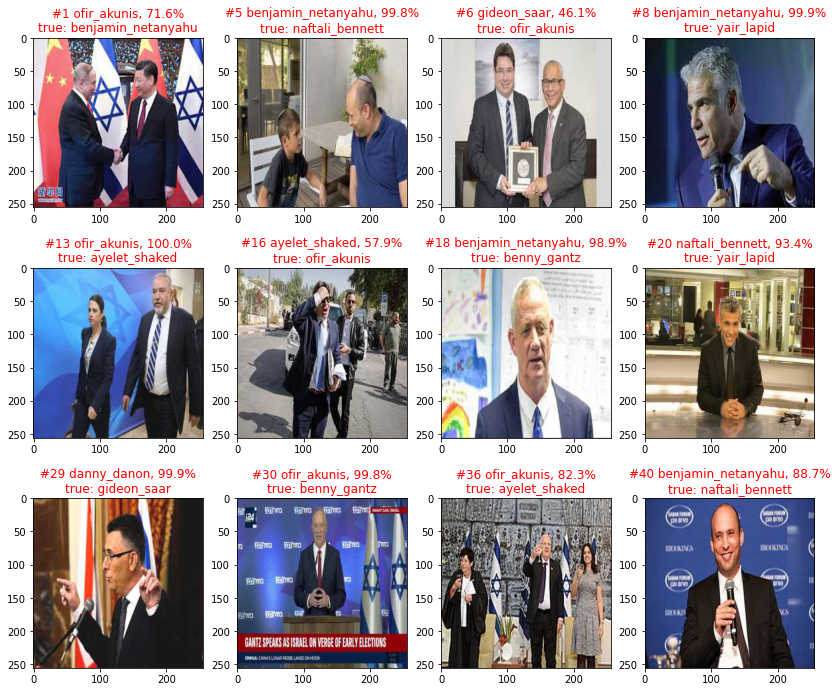

In [ ]:
plot_classes_preds(model, dataiter, images, labels)

> Seemingly because the train data were cleaned from multi-politician samples, the model has difficulties when two or more people present on a sample. And it appears that low sample resolution and unusual posture or lightning are also hard for the model, so targeted data augmentation would help in that.

## Batch Normalization
In this section, we'll add a Batch Norm layer to your network.  
Use TensorBoard to compare the network's convergence (train and validation loss) with and without Batch Normalization.

> We add Batch Normalization layer after the last convolution layer, i.e. before the first dense layer which has the largest number of trainable parameters. Batch Normalization has a positive effect on the model convergence: while the default model's validation loss starts to rise after reaching a minimum at about epoch $10A$, with batch normalization it decreases on run $A$ and reaches a plateau in run $B$ (see the **SCALARS** tab).

In [ ]:
class NetBN(nn.Module):

    def __init__(self, k_size=3, fc1_fc2=2345):

        k_2 = k_size // 2

        super(NetBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(k_size, k_size), stride=(1, 1), padding=(k_2, k_2))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(k_size, k_size), stride=(1, 1), padding=(k_2, k_2))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(k_size, k_size), stride=(1, 1), padding=(k_2, k_2))
        self.conv3_bn = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        self.fc1 = nn.Linear(256 * 4 * 4, fc1_fc2)
        #self.fc1_bn = nn.BatchNorm1d(fc1_fc2)
        self.fc2 = nn.Linear(fc1_fc2, 9)


    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Use TensorBoard to plot the distribution of activations with and without Batch Normalization.

> See the **HISTOGRAMS** tab.

In [ ]:
model_bn = NetBN()

In [ ]:
print(model_bn)

NetBN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=2345, bias=True)
  (fc2): Linear(in_features=2345, out_features=9, bias=True)
)


In [ ]:
channels, H, W = 3, 256, 256
summary(model_bn, input_size=(channels, H, W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
         MaxPool2d-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 64, 64]          73,856
         MaxPool2d-4          [-1, 128, 16, 16]               0
            Conv2d-5          [-1, 256, 16, 16]         295,168
       BatchNorm2d-6          [-1, 256, 16, 16]             512
         MaxPool2d-7            [-1, 256, 4, 4]               0
            Linear-8                 [-1, 2345]       9,607,465
            Linear-9                    [-1, 9]          21,114
Total params: 9,999,907
Trainable params: 9,999,907
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 39.30
Params size (MB): 38.15
Estimated Total Size (MB): 78.20
------------------------------------

In [ ]:
model_bn, run = train_model(model_bn, dataloaders, define_params,
    run, run_title='batch_norm_A')

Run #03 batch_norm_A

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 4.3335 Acc: 0.2118
val Loss: 2.0259 Acc: 0.2822
Epoch 2/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.9297 Acc: 0.3227
val Loss: 1.9570 Acc: 0.3366
Epoch 3/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.7654 Acc: 0.3842
val Loss: 1.8462 Acc: 0.3762
Epoch 4/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.5969 Acc: 0.4544
val Loss: 1.7846 Acc: 0.3713
Epoch 5/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.4470 Acc: 0.4877
val Loss: 1.6369 Acc: 0.4307
Epoch 6/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.3135 Acc: 0.5567
val Loss: 1.6563 Acc: 0.4307
Epoch 7/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.2076 Acc: 0.5837
val Loss: 1.6135 Acc: 0.4752
Epoch 8/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.0291 Acc: 0.6490
val Loss: 1.3950 Acc: 0.5198
Epoch 9/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.9219 Acc: 0.6995
val Loss: 1.4451 Acc: 0.4851
Epoch 10/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7386 Acc: 0.7820
val Loss: 1.3708 Acc: 0.5495
Epoch 11/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6439 Acc: 0.8153
val Loss: 1.4363 Acc: 0.5594
Epoch 12/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5702 Acc: 0.8461
val Loss: 1.3218 Acc: 0.5941
Epoch 13/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.4176 Acc: 0.8978
val Loss: 1.1541 Acc: 0.6436
Epoch 14/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.3535 Acc: 0.9039
val Loss: 1.1954 Acc: 0.6337
Epoch 15/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.3006 Acc: 0.9360
val Loss: 1.3493 Acc: 0.6337
Epoch 16/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.2398 Acc: 0.9569
val Loss: 1.1344 Acc: 0.6584
Epoch 17/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.2003 Acc: 0.9655
val Loss: 1.1598 Acc: 0.6931
Epoch 18/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1631 Acc: 0.9803
val Loss: 1.1541 Acc: 0.6832
Epoch 19/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1268 Acc: 0.9914
val Loss: 1.0789 Acc: 0.7030
Epoch 20/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1139 Acc: 0.9926
val Loss: 1.0962 Acc: 0.6980


In [ ]:
model_bn, run = train_model(model_bn, dataloaders, define_params,
    run, run_title='batch_norm_B')

Run #04 batch_norm_B

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7316 Acc: 0.7488
val Loss: 1.1391 Acc: 0.6436
Epoch 2/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.4419 Acc: 0.8448
val Loss: 1.2775 Acc: 0.6782
Epoch 3/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.3070 Acc: 0.9064
val Loss: 1.3706 Acc: 0.6485
Epoch 4/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1471 Acc: 0.9581
val Loss: 1.4314 Acc: 0.6980
Epoch 5/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.1028 Acc: 0.9754
val Loss: 1.3073 Acc: 0.6683
Epoch 6/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0576 Acc: 0.9901
val Loss: 1.4770 Acc: 0.7228
Epoch 7/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0226 Acc: 0.9988
val Loss: 1.3879 Acc: 0.7178
Epoch 8/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0112 Acc: 1.0000
val Loss: 1.3503 Acc: 0.7426
Epoch 9/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0082 Acc: 1.0000
val Loss: 1.3140 Acc: 0.7228
Epoch 10/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0067 Acc: 1.0000
val Loss: 1.3252 Acc: 0.7426
Epoch 11/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0052 Acc: 1.0000
val Loss: 1.2920 Acc: 0.7376
Epoch 12/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0052 Acc: 1.0000
val Loss: 1.3714 Acc: 0.7376
Epoch 13/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0046 Acc: 1.0000
val Loss: 1.3683 Acc: 0.7327
Epoch 14/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0047 Acc: 1.0000
val Loss: 1.3348 Acc: 0.7327
Epoch 15/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0037 Acc: 1.0000
val Loss: 1.3457 Acc: 0.7426
Epoch 16/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0037 Acc: 1.0000
val Loss: 1.3427 Acc: 0.7277
Epoch 17/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0035 Acc: 1.0000
val Loss: 1.3979 Acc: 0.7376
Epoch 18/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0029 Acc: 1.0000
val Loss: 1.3769 Acc: 0.7277
Epoch 19/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0034 Acc: 1.0000
val Loss: 1.3952 Acc: 0.7376
Epoch 20/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.0029 Acc: 1.0000
val Loss: 1.3765 Acc: 0.7327


## Custom Loss Function
Manually labeled datasets often contain labeling errors. These can have a large effect on the trained model. In this task we’ll work on a highly noisy dataset. Take our cleaned Israeli Politicians dataset and randomly replace 10% of the true labels. Compare the performance of the original model to a similar model trained on the noisy labels. 

Suggest a loss function that might help with noisy labels. Following this guide, implement your own custom loss function in PyTorch and compare the model performance using it:  
https://discuss.pytorch.org/t/solved-what-is-the-correct-way-to-implement-custom-loss-function/3568/9


> We employed random labelling with full randomization $-$ for $10\%$ of train labels, both samples selected for changing and new labels were chosen randomly and independently within each batch and epoch. As expected, with random labelling the train loss reaches plateau at about $90\%$.

> The stats show that Fully Random Labelling applied alone has similar effect on the model convergence as batch normalization $-$ validation loss achieves the same plateau, and the combination of them has the lowest final validation loss and accuracy among all models.

> Despite the aforementioned positive effect of the Fully Random Labelling, we anyway developed Custom Loss Function as a PyTorch exercise. The function is based on Cross-Entropy Loss, modified in such a way that the final summation doesn't use 10% of the highest log-softmaxed outputs hoping to skew a model to "weak" labels. Employing this function makes final validation loss a bit larger and validation a bit lower, so it seemingly doesn't help.

In [ ]:
model_bn_rl = NetBN()

In [ ]:
model_bn_rl, run = train_model(model_bn_rl, dataloaders, define_params,
    run, run_title='batch_norm_rand_labels_A', rnd_labels=True)

Run #05 batch_norm_rand_labels_A

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 4.5014 Acc: 0.2069
val Loss: 2.1625 Acc: 0.2426
Epoch 2/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 2.0424 Acc: 0.2722
val Loss: 2.0086 Acc: 0.2822
Epoch 3/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.9392 Acc: 0.3054
val Loss: 1.9683 Acc: 0.3020
Epoch 4/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.9143 Acc: 0.3227
val Loss: 1.8967 Acc: 0.3465
Epoch 5/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.8032 Acc: 0.3793
val Loss: 1.7924 Acc: 0.3416
Epoch 6/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.7091 Acc: 0.4163
val Loss: 1.7854 Acc: 0.3960
Epoch 7/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.6967 Acc: 0.4113
val Loss: 1.6810 Acc: 0.3911
Epoch 8/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.6051 Acc: 0.4618
val Loss: 1.6014 Acc: 0.4653
Epoch 9/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.4744 Acc: 0.5049
val Loss: 1.5399 Acc: 0.4802
Epoch 10/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.4053 Acc: 0.5468
val Loss: 1.5832 Acc: 0.4653
Epoch 11/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.3880 Acc: 0.5591
val Loss: 1.4538 Acc: 0.5099
Epoch 12/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.2799 Acc: 0.5788
val Loss: 1.4602 Acc: 0.4604
Epoch 13/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.2030 Acc: 0.6441
val Loss: 1.4335 Acc: 0.5198
Epoch 14/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.2042 Acc: 0.6638
val Loss: 1.3193 Acc: 0.5545
Epoch 15/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.1343 Acc: 0.6946
val Loss: 1.3261 Acc: 0.5594
Epoch 16/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.0929 Acc: 0.7044
val Loss: 1.3151 Acc: 0.5644
Epoch 17/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.0624 Acc: 0.7377
val Loss: 1.2854 Acc: 0.5842
Epoch 18/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.0045 Acc: 0.7562
val Loss: 1.2987 Acc: 0.5644
Epoch 19/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.9535 Acc: 0.7635
val Loss: 1.3059 Acc: 0.5644
Epoch 20/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.9916 Acc: 0.7734
val Loss: 1.3117 Acc: 0.5743


In [ ]:
model_bn_rl, run = train_model(model_bn_rl, dataloaders, define_params,
    run, run_title='batch_norm_rand_labels_B', rnd_labels=True)

Run #06 batch_norm_rand_labels_B

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.3236 Acc: 0.5899
val Loss: 1.3972 Acc: 0.4802
Epoch 2/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.1836 Acc: 0.6736
val Loss: 1.6516 Acc: 0.4703
Epoch 3/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.0528 Acc: 0.7094
val Loss: 1.2922 Acc: 0.5990
Epoch 4/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.9479 Acc: 0.7525
val Loss: 1.3172 Acc: 0.5693
Epoch 5/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.9414 Acc: 0.7734
val Loss: 1.1194 Acc: 0.6584
Epoch 6/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.8763 Acc: 0.7857
val Loss: 1.3628 Acc: 0.5594
Epoch 7/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7772 Acc: 0.8424
val Loss: 1.0869 Acc: 0.6485
Epoch 8/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.8165 Acc: 0.8288
val Loss: 1.0957 Acc: 0.6287
Epoch 9/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7474 Acc: 0.8534
val Loss: 1.0863 Acc: 0.6436
Epoch 10/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7164 Acc: 0.8732
val Loss: 1.0644 Acc: 0.6931
Epoch 11/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6711 Acc: 0.8929
val Loss: 1.0897 Acc: 0.6733
Epoch 12/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6464 Acc: 0.8916
val Loss: 1.0483 Acc: 0.6832
Epoch 13/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6478 Acc: 0.8990
val Loss: 0.9829 Acc: 0.6980
Epoch 14/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5602 Acc: 0.9200
val Loss: 0.9862 Acc: 0.7030
Epoch 15/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6044 Acc: 0.9138
val Loss: 0.9713 Acc: 0.6931
Epoch 16/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6292 Acc: 0.9052
val Loss: 1.0132 Acc: 0.6832
Epoch 17/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5766 Acc: 0.9138
val Loss: 0.9552 Acc: 0.7129
Epoch 18/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5732 Acc: 0.9138
val Loss: 0.9133 Acc: 0.7228
Epoch 19/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6080 Acc: 0.9101
val Loss: 0.9487 Acc: 0.7129
Epoch 20/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5726 Acc: 0.9150
val Loss: 0.8796 Acc: 0.7475


In [ ]:
class CustomLoss(torch.nn.Module):

    def __init__(self):
        super(CustomLoss, self).__init__()


    def forward(self, outputs, labels):
        
        # take log_softmax of output
        outputs = torch.nn.functional.log_softmax(outputs, dim=1)

        # pick the values corresponding to labels
        outputs = torch.sort(outputs[range(outputs.shape[0]), labels])[0]

        n_out = outputs.shape[0] // 10

        # cross-entropy loss for 90% "weak" labels
        return -torch.sum(outputs[:-n_out]) / (outputs.shape[0] - n_out)


def define_params_custom_loss(model):

    _, optimizer, scheduler, num_epochs = define_params(model)
    criterion = CustomLoss()

    return criterion, optimizer, scheduler, num_epochs

In [ ]:
model_rl = Net()
model_rl, run = train_model(model_rl, dataloaders, define_params,
    run, run_title='random_labels_A', rnd_labels=True)

Run #07 random_labels_A

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 2.1258 Acc: 0.2562
val Loss: 2.1387 Acc: 0.2376
Epoch 2/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 2.0387 Acc: 0.2648
val Loss: 2.0277 Acc: 0.2921
Epoch 3/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.9619 Acc: 0.2956
val Loss: 1.8945 Acc: 0.3663
Epoch 4/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.7832 Acc: 0.3867
val Loss: 1.8305 Acc: 0.3614
Epoch 5/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.5990 Acc: 0.4766
val Loss: 1.7551 Acc: 0.4208
Epoch 6/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.4309 Acc: 0.5431
val Loss: 1.6866 Acc: 0.4653
Epoch 7/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.2681 Acc: 0.6429
val Loss: 1.5570 Acc: 0.4851
Epoch 8/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.0157 Acc: 0.7328
val Loss: 1.4475 Acc: 0.5545
Epoch 9/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.8841 Acc: 0.7980
val Loss: 1.4075 Acc: 0.5446
Epoch 10/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7554 Acc: 0.8534
val Loss: 1.3643 Acc: 0.5990
Epoch 11/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6995 Acc: 0.8793
val Loss: 1.3162 Acc: 0.6188
Epoch 12/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7007 Acc: 0.8879
val Loss: 1.3078 Acc: 0.6386
Epoch 13/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6436 Acc: 0.8990
val Loss: 1.3215 Acc: 0.6485
Epoch 14/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6680 Acc: 0.9052
val Loss: 1.3274 Acc: 0.6040
Epoch 15/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6211 Acc: 0.8990
val Loss: 1.2683 Acc: 0.6337
Epoch 16/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6175 Acc: 0.9039
val Loss: 1.2214 Acc: 0.6386
Epoch 17/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5959 Acc: 0.9126
val Loss: 1.2723 Acc: 0.6386
Epoch 18/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5956 Acc: 0.9126
val Loss: 1.2572 Acc: 0.6287
Epoch 19/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5679 Acc: 0.9138
val Loss: 1.2496 Acc: 0.6337
Epoch 20/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5633 Acc: 0.9126
val Loss: 1.2537 Acc: 0.6535


In [ ]:
model_rl, run = train_model(model_rl, dataloaders, define_params,
    run, run_title='random_labels_B', rnd_labels=True)

Run #08 random_labels_B

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7483 Acc: 0.8695
val Loss: 1.2809 Acc: 0.6634
Epoch 2/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6950 Acc: 0.8695
val Loss: 1.3888 Acc: 0.6386
Epoch 3/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7360 Acc: 0.8608
val Loss: 1.4730 Acc: 0.5842
Epoch 4/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7115 Acc: 0.8781
val Loss: 1.2563 Acc: 0.6188
Epoch 5/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6581 Acc: 0.8929
val Loss: 1.2694 Acc: 0.6287
Epoch 6/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6201 Acc: 0.8953
val Loss: 1.2412 Acc: 0.6386
Epoch 7/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5912 Acc: 0.9002
val Loss: 1.1869 Acc: 0.6584
Epoch 8/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5738 Acc: 0.9113
val Loss: 1.1319 Acc: 0.6584
Epoch 9/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6186 Acc: 0.9027
val Loss: 1.2222 Acc: 0.6634
Epoch 10/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5785 Acc: 0.9113
val Loss: 1.1658 Acc: 0.6782
Epoch 11/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5862 Acc: 0.9089
val Loss: 1.0814 Acc: 0.6782
Epoch 12/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5659 Acc: 0.9126
val Loss: 1.1108 Acc: 0.6683
Epoch 13/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5216 Acc: 0.9126
val Loss: 1.0936 Acc: 0.6881
Epoch 14/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5428 Acc: 0.9113
val Loss: 1.1353 Acc: 0.6634
Epoch 15/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5786 Acc: 0.9076
val Loss: 1.1041 Acc: 0.6782
Epoch 16/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5208 Acc: 0.9138
val Loss: 1.0831 Acc: 0.6782
Epoch 17/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5268 Acc: 0.9113
val Loss: 1.0856 Acc: 0.6733
Epoch 18/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5246 Acc: 0.9126
val Loss: 1.0927 Acc: 0.6634
Epoch 19/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.4602 Acc: 0.9212
val Loss: 1.0932 Acc: 0.6683
Epoch 20/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5304 Acc: 0.9126
val Loss: 1.0940 Acc: 0.6733


In [ ]:
model_rl_cl = Net()
model_rl_cl, run = train_model(model_rl_cl, dataloaders, define_params_custom_loss,
    run, run_title='random_labels_custom_loss_A', rnd_labels=True)

Run #09 random_labels_custom_loss_A

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 2.2163 Acc: 0.2340
val Loss: 2.0887 Acc: 0.2376
Epoch 2/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 2.1148 Acc: 0.2771
val Loss: 2.0775 Acc: 0.2772
Epoch 3/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 2.0772 Acc: 0.3054
val Loss: 2.0492 Acc: 0.3020
Epoch 4/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.9764 Acc: 0.3387
val Loss: 1.9041 Acc: 0.3515
Epoch 5/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.8361 Acc: 0.4089
val Loss: 1.8180 Acc: 0.4505
Epoch 6/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.6835 Acc: 0.4754
val Loss: 1.8184 Acc: 0.4505
Epoch 7/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.4852 Acc: 0.5751
val Loss: 1.7108 Acc: 0.4901
Epoch 8/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.3315 Acc: 0.6564
val Loss: 1.7462 Acc: 0.4950
Epoch 9/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 1.1707 Acc: 0.7155
val Loss: 1.7524 Acc: 0.5396
Epoch 10/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.9943 Acc: 0.8054
val Loss: 1.6296 Acc: 0.5693
Epoch 11/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.8885 Acc: 0.8214
val Loss: 1.6342 Acc: 0.5792
Epoch 12/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.8353 Acc: 0.8473
val Loss: 1.5780 Acc: 0.6337
Epoch 13/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.8364 Acc: 0.8805
val Loss: 1.6371 Acc: 0.5891
Epoch 14/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7530 Acc: 0.8941
val Loss: 1.6801 Acc: 0.6139
Epoch 15/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6929 Acc: 0.8941
val Loss: 1.5951 Acc: 0.6238
Epoch 16/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6963 Acc: 0.8904
val Loss: 1.5914 Acc: 0.6238
Epoch 17/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6770 Acc: 0.9089
val Loss: 1.5851 Acc: 0.6188
Epoch 18/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6952 Acc: 0.9064
val Loss: 1.5604 Acc: 0.6386
Epoch 19/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6976 Acc: 0.9015
val Loss: 1.5460 Acc: 0.6337
Epoch 20/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6707 Acc: 0.9076
val Loss: 1.5565 Acc: 0.6139


In [ ]:
model_rl_cl, run = train_model(model_rl_cl, dataloaders, define_params_custom_loss,
    run, run_title='random_labels_custom_loss_B', rnd_labels=True)

Run #10 random_labels_custom_loss_B

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.8570 Acc: 0.8350
val Loss: 1.7961 Acc: 0.6238
Epoch 2/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.8158 Acc: 0.8436
val Loss: 1.8481 Acc: 0.5941
Epoch 3/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7768 Acc: 0.8633
val Loss: 1.6785 Acc: 0.5990
Epoch 4/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.7511 Acc: 0.8818
val Loss: 1.6124 Acc: 0.6040
Epoch 5/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6794 Acc: 0.8953
val Loss: 1.5804 Acc: 0.6287
Epoch 6/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6871 Acc: 0.8904
val Loss: 1.5154 Acc: 0.6238
Epoch 7/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6994 Acc: 0.9027
val Loss: 1.5246 Acc: 0.6584
Epoch 8/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6928 Acc: 0.8990
val Loss: 1.4592 Acc: 0.6287
Epoch 9/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6415 Acc: 0.9089
val Loss: 1.4733 Acc: 0.6287
Epoch 10/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6717 Acc: 0.9027
val Loss: 1.3916 Acc: 0.6584
Epoch 11/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6441 Acc: 0.9076
val Loss: 1.5045 Acc: 0.6337
Epoch 12/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6641 Acc: 0.9076
val Loss: 1.4328 Acc: 0.6535
Epoch 13/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6323 Acc: 0.9101
val Loss: 1.4506 Acc: 0.6535
Epoch 14/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6275 Acc: 0.9052
val Loss: 1.4498 Acc: 0.6485
Epoch 15/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6030 Acc: 0.9089
val Loss: 1.4027 Acc: 0.6386
Epoch 16/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5657 Acc: 0.9138
val Loss: 1.3951 Acc: 0.6634
Epoch 17/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.6015 Acc: 0.9126
val Loss: 1.3762 Acc: 0.6634
Epoch 18/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5676 Acc: 0.9187
val Loss: 1.3837 Acc: 0.6535
Epoch 19/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5789 Acc: 0.9138
val Loss: 1.3550 Acc: 0.6733
Epoch 20/20
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


train Loss: 0.5813 Acc: 0.9126
val Loss: 1.3569 Acc: 0.6485
